### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.5.0


### Set GPU memory growth

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Set seed for reproducibility

In [3]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Splitted dataset folder

In [4]:
# Inspect dataset structure on disk
print("Depth 0 (oversampling_dataset)")
print("-------")
print(os.listdir("oversampling_dataset"))
print()
print("Depth 1 (oversampling_dataset/train)")
print("------------------------")
print(os.listdir("oversampling_dataset/train"))
print()
print("Depth 1 (oversampling_dataset/val)")
print("------------------------")
print(os.listdir("oversampling_dataset/val"))
print()
print("Depth 2 (e.g. oversampling_dataset/val/Apple)")
print("----------------------------")
print(os.listdir("oversampling_dataset/val/Apple"))

Depth 0 (oversampling_dataset)
-------
['train', 'val']

Depth 1 (oversampling_dataset/train)
------------------------
['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']

Depth 1 (oversampling_dataset/val)
------------------------
['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']

Depth 2 (e.g. oversampling_dataset/val/Apple)
----------------------------
['00008.jpg', '00014.jpg', '00030.jpg', '00032.jpg', '00035.jpg', '00037.jpg', '00055.jpg', '00058.jpg', '00060.jpg', '00073.jpg', '00083.jpg', '00088.jpg', '00094.jpg', '00096.jpg', '00104.jpg', '00105.jpg', '00113.jpg', '00119.jpg', '00120.jpg', '00122.jpg', '00127.jpg', '00132.jpg', '00134.jpg', '00144.jpg', '00146.jpg', '00149.jpg', '00163.jpg', '00181.jpg', '00182.jpg', '00186.jpg', '00199.jpg', '00202.jpg', '00206.jpg', '00210.jpg', '00211.

In [5]:
# Dataset folders
dataset_dir = 'oversampling_dataset'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

## Data Loader <br>
We create 2 generators to read/load images from the dataset directory:

*   The first generator will load images from the training directory
*   The second generator will load images from the validation directory<br>

We use the tensorflow ImageDataGenerator class which also allows to define some transformations to apply for data augmentation to our training dataset. <br>
We use a batch size of 16.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
aug_train_datagen = ImageDataGenerator(rotation_range=30,
                                       height_shift_range=30,
                                       width_shift_range=30,
                                       zoom_range=[0.7,1.3],
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest',
                                       brightness_range=[0.6, 1.5],
                                       shear_range=10.0,
                                       channel_shift_range=60,
                                       rescale=1/255.)

val_datagen = ImageDataGenerator(rescale=1/255.)

aug_train_gen = aug_train_datagen.flow_from_directory(directory=training_dir,
                                                          target_size=(256,256),
                                                          color_mode='rgb',
                                                          classes=None,
                                                          class_mode='categorical',
                                                          batch_size=16,
                                                          shuffle=True,
                                                          seed=seed)
val_gen = val_datagen.flow_from_directory(directory=validation_dir,
                                          target_size=(256,256),
                                          color_mode='rgb',
                                          classes=None, 
                                          class_mode='categorical',
                                          batch_size=16,
                                          shuffle=False,
                                          seed=seed
                                          )

Found 77042 images belonging to 14 classes.
Found 2660 images belonging to 14 classes.


In [8]:
# How the generator assigns labels
print("Assigned labels")
print(aug_train_gen.class_indices)
print()
print('Target classes')
print(aug_train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


### Model metadata

In [9]:
input_shape = (256, 256, 3)
epochs = 100

# CNN model (without Transfer Learning)

The model proposed by us can be divided into 2 parts: one dedicated to features extraction and the other to classification.<br><br>
The first part is composed by 6 'blocks' each one cointaining:
*   Convolutional layer with 3 x 3 filters (whose depth increases from block to block, from 16 to 512)
*   Batch Normalization
*   Activation layer with Relu
*   Max pooling layer 2 x 2

The second part is composed by:
*   1 Flatten layer + Dropout of 0.4
*   1 Dense layer with 512 units + Batch Normalization + Relu +  Dropout of 0.4
*   1 Dense (output) layer with 14 units + Batch Normalization + Softmax
<br>

We compile the model with:
*   Loss function: Categorical Cross-Entropy
*   Optimizer: Adam with learning rate of 0.001
*   Metric: Accuracy



In [10]:
# (Conv + BatchNo + Relu + MaxPool) x 6 + FC x 2
def build_model(input_shape):
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer) 
    x = tfkl.BatchNormalization()(x)
    x = tfk.activations.relu(x) 
    x = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(x)
    
    
    x = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(x)
    x = tfkl.BatchNormalization()(x)
    x = tfk.activations.relu(x)
    x = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(x) 
    
    x = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(x)
    x = tfkl.BatchNormalization()(x)
    x = tfk.activations.relu(x)
    x = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(x)
    
    x = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(x)
    x = tfkl.BatchNormalization()(x)
    x = tfk.activations.relu(x)
    x = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(x) 
    
    x = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(x)
    x = tfkl.BatchNormalization()(x)
    x = tfk.activations.relu(x)
    x = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(x)
    
    x = tfkl.Conv2D(
        filters=512,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(x)
    x = tfkl.BatchNormalization()(x)
    x = tfk.activations.relu(x)
    x = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(x)
    
    x = tfkl.Flatten(name='Flatten')(x)
    x = tfkl.Dropout(0.4, seed=seed)(x)
    
    x = tfkl.Dense(units=512, name='Classifier1', kernel_initializer=tfk.initializers.GlorotUniform(seed))(x)
    x = tfkl.BatchNormalization()(x)
    x = tfk.activations.relu(x)
    x = tfkl.Dropout(0.4, seed=seed)(x)
    
    output_layer = tfkl.Dense(units=14, kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)
    output_layer = tfkl.BatchNormalization()(output_layer)
    output_layer = tfk.activations.softmax(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics='accuracy')

    # Return the model
    return model


In [11]:
# Build model
model = build_model(input_shape)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128   

In [13]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 5.0 MB/s 


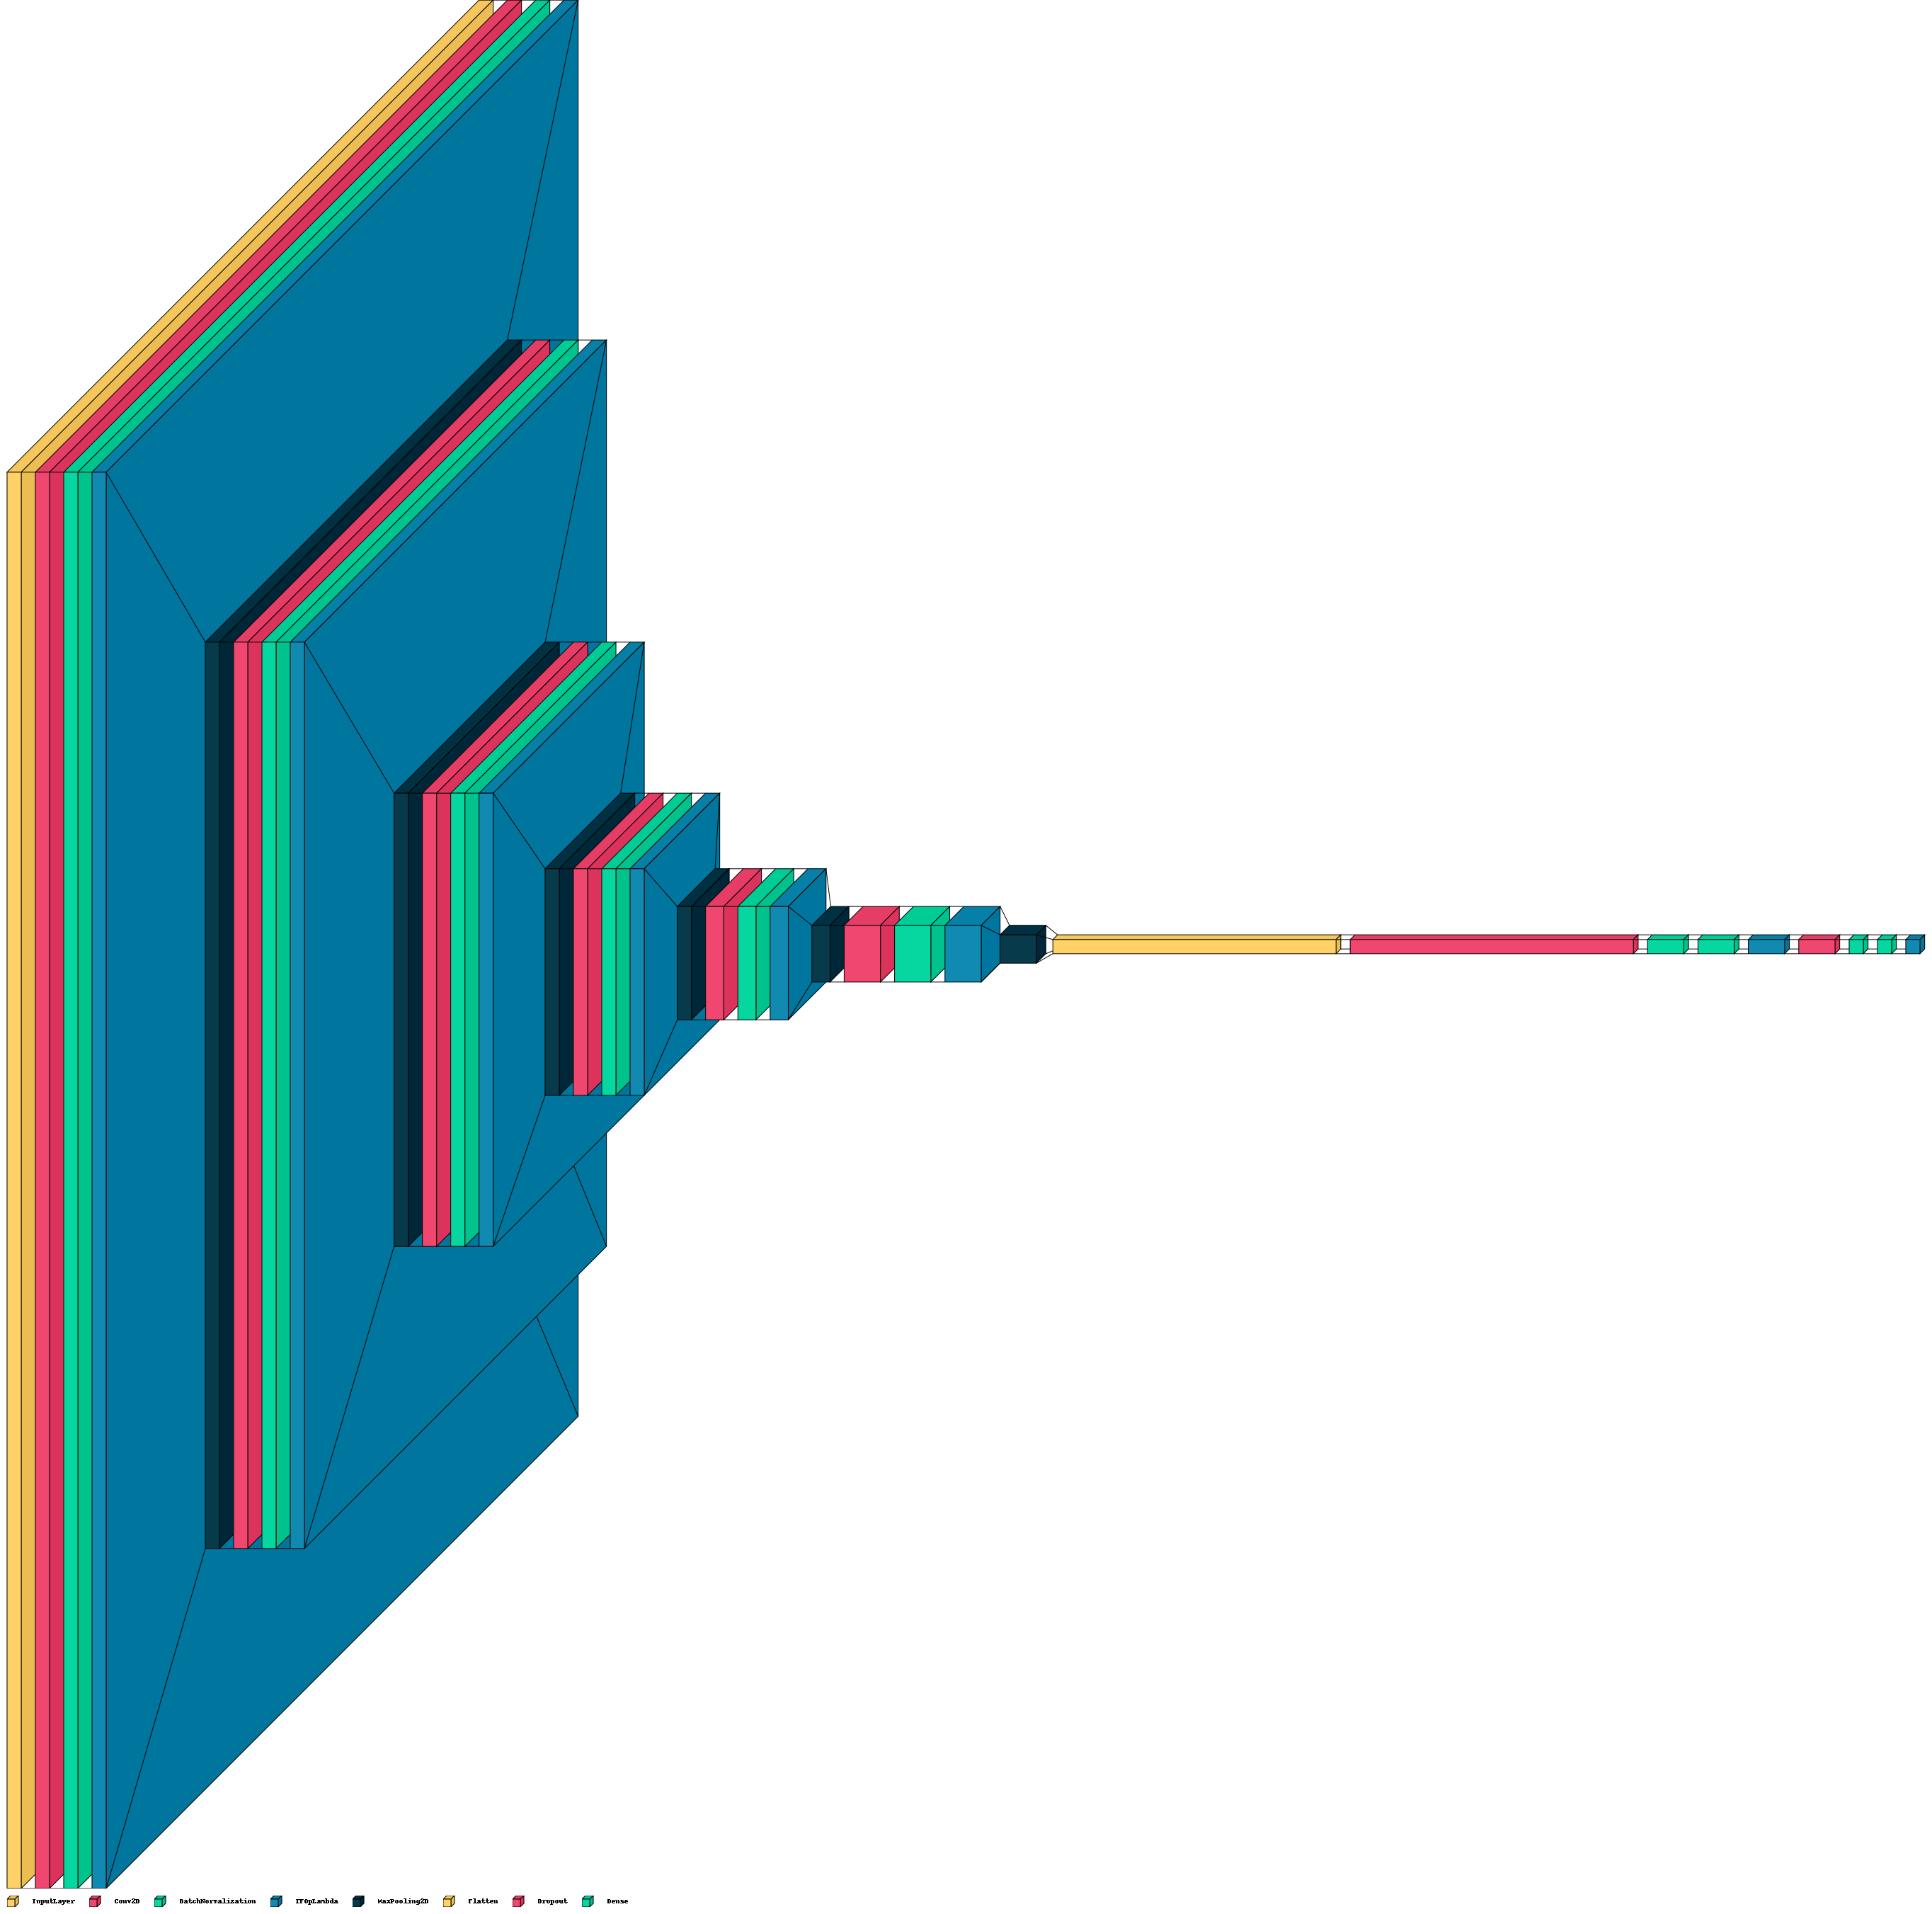

In [14]:
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

### Callbacks

We use 3 callbacks during training:
*   ckpt_callback: callback for saving checkpoints
*   tb_callback: callback for saving the training logs to visualize the training on Tensorboard
*   es_callback: callback for applying Early Stopping in order to limit overfitting

In [12]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
 
  now = datetime.now().strftime('%b%d_%H-%M-%S')
      
  callbacks = []

  # Model checkpoint
  # ----------------
  path1 = 'my_experiments' + '/' + model_name + '_' + str(now) + '/' + 'ckpts' + '/' + 'cp.ckpt'
  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path1, 
                                                     save_weights_only=False, 
                                                     save_best_only=False) 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  path2 = 'my_experiments' + '/' + model_name + '_' + str(now) + '/' + 'tb_logs'
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=path2, 
                                               profile_batch=0,
                                               histogram_freq=1)  
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

### Training

In [13]:
aug_callbacks = create_folders_and_callbacks(model_name='CNN27') # create folders and callbacks for training

tf.get_logger().setLevel('WARNING') #  if you want to suppress only INFOs

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/100
4816/4816 [==============================] - 1272s 262ms/step - loss: 1.0746 - accuracy: 0.6658 - val_loss: 0.3820 - val_accuracy: 0.8771


Epoch 2/100
4816/4816 [==============================] - 1242s 258ms/step - loss: 0.5045 - accuracy: 0.8522 - val_loss: 0.4713 - val_accuracy: 0.8556


Epoch 3/100
4816/4816 [==============================] - 1250s 260ms/step - loss: 0.3111 - accuracy: 0.9132 - val_loss: 0.2235 - val_accuracy: 0.9353


Epoch 4/100
4816/4816 [==============================] - 1257s 261ms/step - loss: 0.2634 - accuracy: 0.9252 - val_loss: 0.1807 - val_accuracy: 0.9466


Epoch 5/100
4816/4816 [==============================] - 1258s 261ms/step - loss: 0.1923 - accuracy: 0.9464 - val_loss: 0.1144 - val_accuracy: 0.9635


Epoch 6/100
4816/4816 [==============================] - 1250s 260ms/step - loss: 0.1537 - accuracy: 0.9570 - val_loss: 0.2250 - val_accuracy: 0.9278


Epoch 7/100
4816/4816 [==============================] - 1272s 264ms/step - loss: 0.1296 - accuracy: 0.9639 - val_loss: 0.1089 - val_accuracy: 0.9605


Epoch 8/100
4816/4816 [==============================] - 1248s 259ms/step - loss: 0.1121 - accuracy: 0.9687 - val_loss: 0.0914 - val_accuracy: 0.9654


Epoch 9/100
4816/4816 [==============================] - 1259s 261ms/step - loss: 0.1026 - accuracy: 0.9710 - val_loss: 0.0404 - val_accuracy: 0.9868


Epoch 10/100
4816/4816 [==============================] - 1249s 259ms/step - loss: 0.0852 - accuracy: 0.9764 - val_loss: 0.1388 - val_accuracy: 0.9586


Epoch 11/100
4816/4816 [==============================] - 1260s 262ms/step - loss: 0.0788 - accuracy: 0.9775 - val_loss: 0.0192 - val_accuracy: 0.9947


Epoch 12/100
4816/4816 [==============================] - 1266s 263ms/step - loss: 0.0712 - accuracy: 0.9800 - val_loss: 0.0539 - val_accuracy: 0.9808


Epoch 13/100
4816/4816 [==============================] - 1269s 263ms/step - loss: 0.0668 - accuracy: 0.9813 - val_loss: 0.0296 - val_accuracy: 0.9883


Epoch 14/100
4816/4816 [==============================] - 1249s 259ms/step - loss: 0.0627 - accuracy: 0.9823 - val_loss: 0.0489 - val_accuracy: 0.9872


Epoch 15/100
4816/4816 [==============================] - 1264s 262ms/step - loss: 0.0592 - accuracy: 0.9830 - val_loss: 0.0225 - val_accuracy: 0.9925


Epoch 16/100
4816/4816 [==============================] - 1246s 259ms/step - loss: 0.0535 - accuracy: 0.9840 - val_loss: 0.0203 - val_accuracy: 0.9951


Epoch 17/100
4816/4816 [==============================] - 1236s 257ms/step - loss: 0.0517 - accuracy: 0.9847 - val_loss: 0.0188 - val_accuracy: 0.9947


Epoch 18/100
4816/4816 [==============================] - 1243s 258ms/step - loss: 0.0507 - accuracy: 0.9853 - val_loss: 0.0233 - val_accuracy: 0.9929


Epoch 19/100
4816/4816 [==============================] - 1233s 256ms/step - loss: 0.0463 - accuracy: 0.9863 - val_loss: 0.0187 - val_accuracy: 0.9955


Epoch 20/100
4816/4816 [==============================] - 1237s 257ms/step - loss: 0.0438 - accuracy: 0.9871 - val_loss: 0.0853 - val_accuracy: 0.9714


Epoch 21/100
4816/4816 [==============================] - 1246s 259ms/step - loss: 0.0422 - accuracy: 0.9879 - val_loss: 0.0205 - val_accuracy: 0.9929


Epoch 22/100
4816/4816 [==============================] - 1241s 258ms/step - loss: 0.0404 - accuracy: 0.9881 - val_loss: 0.0153 - val_accuracy: 0.9951


Epoch 23/100
4816/4816 [==============================] - 1246s 259ms/step - loss: 0.0379 - accuracy: 0.9891 - val_loss: 0.0175 - val_accuracy: 0.9947


Epoch 24/100
4816/4816 [==============================] - 1246s 259ms/step - loss: 0.0349 - accuracy: 0.9896 - val_loss: 0.0584 - val_accuracy: 0.9850


Epoch 25/100
4816/4816 [==============================] - 1263s 262ms/step - loss: 0.0348 - accuracy: 0.9898 - val_loss: 0.0228 - val_accuracy: 0.9925


Epoch 26/100
4816/4816 [==============================] - 1278s 265ms/step - loss: 0.0351 - accuracy: 0.9897 - val_loss: 0.0123 - val_accuracy: 0.9970


Epoch 27/100
4816/4816 [==============================] - 1240s 257ms/step - loss: 0.0493 - accuracy: 0.9855 - val_loss: 0.0084 - val_accuracy: 0.9974


Epoch 28/100
4816/4816 [==============================] - 1249s 259ms/step - loss: 0.0261 - accuracy: 0.9924 - val_loss: 0.0207 - val_accuracy: 0.9936


Epoch 29/100
4816/4816 [==============================] - 1244s 258ms/step - loss: 0.0336 - accuracy: 0.9903 - val_loss: 0.0142 - val_accuracy: 0.9966


Epoch 30/100
4816/4816 [==============================] - 1234s 256ms/step - loss: 0.0330 - accuracy: 0.9907 - val_loss: 0.0276 - val_accuracy: 0.9914


Epoch 31/100
4816/4816 [==============================] - 1232s 256ms/step - loss: 0.0297 - accuracy: 0.9915 - val_loss: 0.0173 - val_accuracy: 0.9940


Epoch 32/100
4816/4816 [==============================] - 1230s 255ms/step - loss: 0.0299 - accuracy: 0.9914 - val_loss: 0.0260 - val_accuracy: 0.9921


Epoch 33/100
4816/4816 [==============================] - 1234s 256ms/step - loss: 0.0283 - accuracy: 0.9919 - val_loss: 0.0241 - val_accuracy: 0.9944


Epoch 34/100
4816/4816 [==============================] - 1232s 256ms/step - loss: 0.0283 - accuracy: 0.9917 - val_loss: 0.0141 - val_accuracy: 0.9966


Epoch 35/100
4816/4816 [==============================] - 1238s 257ms/step - loss: 0.0280 - accuracy: 0.9918 - val_loss: 0.0097 - val_accuracy: 0.9985


Epoch 36/100
4816/4816 [==============================] - 1238s 257ms/step - loss: 0.0264 - accuracy: 0.9924 - val_loss: 0.0233 - val_accuracy: 0.9940


Epoch 37/100
4816/4816 [==============================] - 1233s 256ms/step - loss: 0.0262 - accuracy: 0.9924 - val_loss: 0.0252 - val_accuracy: 0.9921


In [14]:
# Save best epoch model
model.save('CNN27')

### Plot the Training

In [15]:
# utility function to plot the training history
def plot_history(history):
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15,5))
    plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

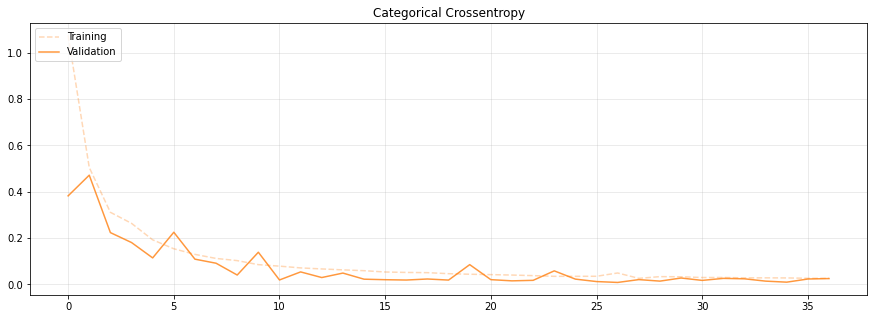

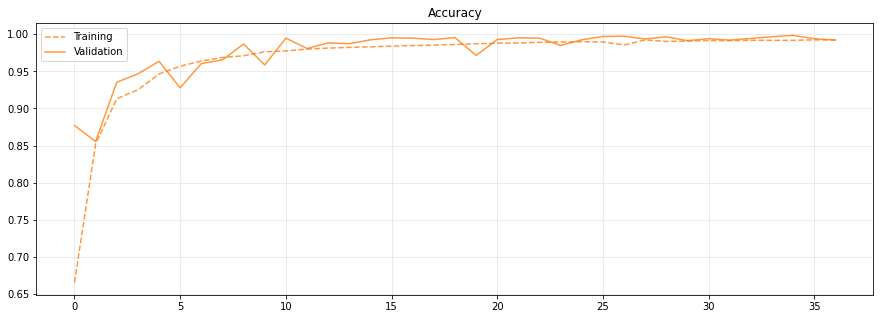

In [16]:
plot_history(history)

### Validation results

In [16]:
# model = tfk.models.load_model('CNN27')

In [17]:
# Utility function to print the Confusion Matrix ad the Classification Report
def classif_report(model):
    Y_pred = model.predict(val_gen)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(val_gen.classes, y_pred))
    print()
    print('Classification Report')
    print()
    print()
    target_names = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']
    print(classification_report(val_gen.classes, y_pred, target_names=target_names))
    print()
    print('Validation metrics:')
    model_metrics = model.evaluate(val_gen, return_dict=True)    

In [18]:
# Confusion Matrix and Classification Report
classif_report(model)

Confusion Matrix
[[190   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 190   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 189   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0 190   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 190   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0 189   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0 189   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0 189   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 189   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0 190   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 190   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0 189   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 190   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0 189]]

Classification Report


              precision    recall  f1-score   support

       Apple       0.99      1.00      0.99       190
   Blueberry       1.0

# Transfer learning and Fine Tuning: Xception
We use the Xception model for transfer learning and fine tuning
([https://arxiv.org/abs/1610.02357](https://arxiv.org/abs/1610.02357)).

We slightly modify our ImageDataGenerator by including the preprocessing function used by Xception
(We don't use anymore the rescale 1/255.). <br>
The inputs pixel values are scaled between -1 and 1, sample-wise.

In [19]:
# We process our images with the preprocessing function used by Xception
from tensorflow.keras.applications.xception import preprocess_input

In [20]:
aug_train_datagen = ImageDataGenerator(rotation_range=30,
                                       height_shift_range=30,
                                       width_shift_range=30,
                                       zoom_range=[0.7,1.3],
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest',
                                       brightness_range=[0.6, 1.5],
                                       shear_range=10.0,
                                       channel_shift_range=60,
                                       preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

aug_train_gen = aug_train_datagen.flow_from_directory(directory=training_dir,
                                                          target_size=(256,256),
                                                          color_mode='rgb',
                                                          classes=None,
                                                          class_mode='categorical',
                                                          batch_size=16,
                                                          shuffle=True,
                                                          seed=seed)
val_gen = val_datagen.flow_from_directory(directory=validation_dir,
                                          target_size=(256,256),
                                          color_mode='rgb',
                                          classes=None, 
                                          class_mode='categorical',
                                          batch_size=16,
                                          shuffle=False,
                                          seed=seed
                                          )

Found 77042 images belonging to 14 classes.
Found 2660 images belonging to 14 classes.


## Transfer Learning

In [21]:
# Download the Xception model
supernet = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
supernet.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

We use the supernet as feature extractor. <br>
We modify the 'head' of the pretrained network by using:
*   1 Global Average Pooling layer + Dropout of 0.2
*   1 Dense (output) layer with 14 units + Softmax

We compile the model with:
*   Loss function: Categorical Cross-Entropy
*   Optimizer: Adam with learning rate of 0.0001
*   Metric: Accuracy

In [22]:
# Use the supernet as feature extractor
supernet.trainable = False

model = tf.keras.models.Sequential()
model.add(supernet)
model.add(tfkl.GlobalAveragePooling2D())
model.add(tfkl.Dropout(0.2, seed=seed))
model.add(tfkl.Dense(14,activation='softmax', kernel_initializer = tfk.initializers.GlorotUniform(seed)))

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 14)                28686     
Total params: 20,890,166
Trainable params: 28,686
Non-trainable params: 20,861,480
_________________________________________________________________


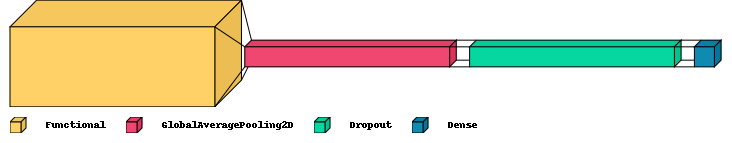

In [ ]:
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

### Training
We use the same callbacks as before

In [23]:
aug_callbacks = create_folders_and_callbacks(model_name='CNN38') # create folders and callbacks for training

tf.get_logger().setLevel('WARNING') # if you want to suppress only INFOs

history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = aug_callbacks,
).history

C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
4816/4816 [==============================] - 1276s 264ms/step - loss: 0.9374 - accuracy: 0.7676 - val_loss: 0.4637 - val_accuracy: 0.9023


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
4816/4816 [==============================] - 1265s 263ms/step - loss: 0.4547 - accuracy: 0.8792 - val_loss: 0.3151 - val_accuracy: 0.9259


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/100
4816/4816 [==============================] - 1292s 268ms/step - loss: 0.3544 - accuracy: 0.9035 - val_loss: 0.2605 - val_accuracy: 0.9316


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/100
4816/4816 [==============================] - 1350s 280ms/step - loss: 0.3063 - accuracy: 0.9144 - val_loss: 0.2216 - val_accuracy: 0.9436


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/100
4816/4816 [==============================] - 1323s 275ms/step - loss: 0.2725 - accuracy: 0.9236 - val_loss: 0.2014 - val_accuracy: 0.9496


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/100
4816/4816 [==============================] - 1327s 275ms/step - loss: 0.2533 - accuracy: 0.9282 - val_loss: 0.1835 - val_accuracy: 0.9530


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/100
4816/4816 [==============================] - 1338s 278ms/step - loss: 0.2397 - accuracy: 0.9306 - val_loss: 0.1693 - val_accuracy: 0.9553


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/100
4816/4816 [==============================] - 1362s 283ms/step - loss: 0.2248 - accuracy: 0.9346 - val_loss: 0.1581 - val_accuracy: 0.9579


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/100
4816/4816 [==============================] - 1409s 292ms/step - loss: 0.2172 - accuracy: 0.9366 - val_loss: 0.1573 - val_accuracy: 0.9590


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/100
4816/4816 [==============================] - 1412s 293ms/step - loss: 0.2104 - accuracy: 0.9375 - val_loss: 0.1488 - val_accuracy: 0.9590


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/100
4816/4816 [==============================] - 1424s 295ms/step - loss: 0.2011 - accuracy: 0.9400 - val_loss: 0.1430 - val_accuracy: 0.9613


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/100
4816/4816 [==============================] - 1434s 298ms/step - loss: 0.1941 - accuracy: 0.9434 - val_loss: 0.1356 - val_accuracy: 0.9639


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/100
4816/4816 [==============================] - 1402s 291ms/step - loss: 0.1907 - accuracy: 0.9427 - val_loss: 0.1325 - val_accuracy: 0.9665


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/100
4816/4816 [==============================] - 1412s 293ms/step - loss: 0.1849 - accuracy: 0.9447 - val_loss: 0.1301 - val_accuracy: 0.9635


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/100
4816/4816 [==============================] - 1412s 293ms/step - loss: 0.1823 - accuracy: 0.9448 - val_loss: 0.1245 - val_accuracy: 0.9669


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/100
4816/4816 [==============================] - 1437s 298ms/step - loss: 0.1789 - accuracy: 0.9456 - val_loss: 0.1217 - val_accuracy: 0.9680


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/100
4816/4816 [==============================] - 1474s 306ms/step - loss: 0.1762 - accuracy: 0.9470 - val_loss: 0.1170 - val_accuracy: 0.9707


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/100
4816/4816 [==============================] - 1504s 312ms/step - loss: 0.1737 - accuracy: 0.9467 - val_loss: 0.1184 - val_accuracy: 0.9669


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/100
4816/4816 [==============================] - 1512s 314ms/step - loss: 0.1695 - accuracy: 0.9492 - val_loss: 0.1161 - val_accuracy: 0.9692


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/100
4816/4816 [==============================] - 1511s 314ms/step - loss: 0.1673 - accuracy: 0.9497 - val_loss: 0.1111 - val_accuracy: 0.9707


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/100
4816/4816 [==============================] - 1491s 309ms/step - loss: 0.1646 - accuracy: 0.9502 - val_loss: 0.1078 - val_accuracy: 0.9722


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/100
4816/4816 [==============================] - 1560s 324ms/step - loss: 0.1642 - accuracy: 0.9508 - val_loss: 0.1091 - val_accuracy: 0.9718


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/100
4816/4816 [==============================] - 1511s 314ms/step - loss: 0.1614 - accuracy: 0.9508 - val_loss: 0.1079 - val_accuracy: 0.9707


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/100
4816/4816 [==============================] - 1542s 320ms/step - loss: 0.1579 - accuracy: 0.9517 - val_loss: 0.1035 - val_accuracy: 0.9711


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/100
4816/4816 [==============================] - 1451s 301ms/step - loss: 0.1597 - accuracy: 0.9510 - val_loss: 0.1028 - val_accuracy: 0.9718


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/100
4816/4816 [==============================] - 1527s 317ms/step - loss: 0.1586 - accuracy: 0.9504 - val_loss: 0.1027 - val_accuracy: 0.9718


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/100
4816/4816 [==============================] - 1502s 312ms/step - loss: 0.1530 - accuracy: 0.9528 - val_loss: 0.1041 - val_accuracy: 0.9711


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/100
4816/4816 [==============================] - 1554s 323ms/step - loss: 0.1520 - accuracy: 0.9540 - val_loss: 0.1033 - val_accuracy: 0.9707


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/100
4816/4816 [==============================] - 1510s 313ms/step - loss: 0.1532 - accuracy: 0.9531 - val_loss: 0.0976 - val_accuracy: 0.9741


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/100
4816/4816 [==============================] - 1523s 316ms/step - loss: 0.1516 - accuracy: 0.9532 - val_loss: 0.0989 - val_accuracy: 0.9741


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/100
4816/4816 [==============================] - 1575s 327ms/step - loss: 0.1493 - accuracy: 0.9543 - val_loss: 0.0974 - val_accuracy: 0.9748


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 32/100
4816/4816 [==============================] - 1567s 325ms/step - loss: 0.1496 - accuracy: 0.9536 - val_loss: 0.0972 - val_accuracy: 0.9729


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 33/100
4816/4816 [==============================] - 1581s 328ms/step - loss: 0.1473 - accuracy: 0.9537 - val_loss: 0.0971 - val_accuracy: 0.9737


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/100
4816/4816 [==============================] - 1556s 323ms/step - loss: 0.1467 - accuracy: 0.9543 - val_loss: 0.0950 - val_accuracy: 0.9741


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/100
4816/4816 [==============================] - 1558s 323ms/step - loss: 0.1453 - accuracy: 0.9560 - val_loss: 0.0924 - val_accuracy: 0.9729


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 36/100
4816/4816 [==============================] - 1592s 331ms/step - loss: 0.1455 - accuracy: 0.9550 - val_loss: 0.0950 - val_accuracy: 0.9741


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/100
4816/4816 [==============================] - 1550s 322ms/step - loss: 0.1421 - accuracy: 0.9550 - val_loss: 0.0970 - val_accuracy: 0.9718


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 38/100
4816/4816 [==============================] - 1515s 314ms/step - loss: 0.1426 - accuracy: 0.9555 - val_loss: 0.0919 - val_accuracy: 0.9756


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 39/100
4816/4816 [==============================] - 1492s 310ms/step - loss: 0.1430 - accuracy: 0.9558 - val_loss: 0.0906 - val_accuracy: 0.9744


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 40/100
4816/4816 [==============================] - 1490s 309ms/step - loss: 0.1421 - accuracy: 0.9555 - val_loss: 0.0877 - val_accuracy: 0.9741


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 41/100
4816/4816 [==============================] - 1446s 300ms/step - loss: 0.1399 - accuracy: 0.9558 - val_loss: 0.0891 - val_accuracy: 0.9756


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 42/100
4816/4816 [==============================] - 1508s 313ms/step - loss: 0.1379 - accuracy: 0.9572 - val_loss: 0.0888 - val_accuracy: 0.9756


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 43/100
4816/4816 [==============================] - 1536s 319ms/step - loss: 0.1378 - accuracy: 0.9563 - val_loss: 0.0918 - val_accuracy: 0.9748


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 44/100
4816/4816 [==============================] - 1564s 325ms/step - loss: 0.1384 - accuracy: 0.9570 - val_loss: 0.0872 - val_accuracy: 0.9752


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 45/100
4816/4816 [==============================] - 1544s 320ms/step - loss: 0.1355 - accuracy: 0.9569 - val_loss: 0.0884 - val_accuracy: 0.9763


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 46/100
4816/4816 [==============================] - 1551s 322ms/step - loss: 0.1372 - accuracy: 0.9564 - val_loss: 0.0858 - val_accuracy: 0.9752


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 47/100
4816/4816 [==============================] - 1582s 329ms/step - loss: 0.1376 - accuracy: 0.9570 - val_loss: 0.0885 - val_accuracy: 0.9763


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 48/100
4816/4816 [==============================] - 1543s 320ms/step - loss: 0.1381 - accuracy: 0.9565 - val_loss: 0.0860 - val_accuracy: 0.9756


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 49/100
4816/4816 [==============================] - 1638s 340ms/step - loss: 0.1354 - accuracy: 0.9565 - val_loss: 0.0858 - val_accuracy: 0.9756


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 50/100
4816/4816 [==============================] - 1555s 323ms/step - loss: 0.1347 - accuracy: 0.9584 - val_loss: 0.0854 - val_accuracy: 0.9763


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 51/100
4816/4816 [==============================] - 1670s 347ms/step - loss: 0.1330 - accuracy: 0.9575 - val_loss: 0.0836 - val_accuracy: 0.9756


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 52/100
4816/4816 [==============================] - 1550s 322ms/step - loss: 0.1343 - accuracy: 0.9571 - val_loss: 0.0857 - val_accuracy: 0.9763


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 53/100
4816/4816 [==============================] - 1628s 338ms/step - loss: 0.1332 - accuracy: 0.9581 - val_loss: 0.0832 - val_accuracy: 0.9782


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 54/100
4816/4816 [==============================] - 1521s 316ms/step - loss: 0.1323 - accuracy: 0.9589 - val_loss: 0.0840 - val_accuracy: 0.9763


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 55/100
4816/4816 [==============================] - 1514s 314ms/step - loss: 0.1320 - accuracy: 0.9579 - val_loss: 0.0818 - val_accuracy: 0.9774


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 56/100
4816/4816 [==============================] - 1510s 313ms/step - loss: 0.1316 - accuracy: 0.9585 - val_loss: 0.0841 - val_accuracy: 0.9763


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 57/100
4816/4816 [==============================] - 1493s 310ms/step - loss: 0.1285 - accuracy: 0.9593 - val_loss: 0.0854 - val_accuracy: 0.9759


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 58/100
4816/4816 [==============================] - 1545s 321ms/step - loss: 0.1313 - accuracy: 0.9582 - val_loss: 0.0854 - val_accuracy: 0.9771


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 59/100
4816/4816 [==============================] - 1537s 319ms/step - loss: 0.1315 - accuracy: 0.9588 - val_loss: 0.0820 - val_accuracy: 0.9748


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 60/100
4816/4816 [==============================] - 1527s 317ms/step - loss: 0.1314 - accuracy: 0.9585 - val_loss: 0.0836 - val_accuracy: 0.9771


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 61/100
4816/4816 [==============================] - 1495s 310ms/step - loss: 0.1301 - accuracy: 0.9582 - val_loss: 0.0844 - val_accuracy: 0.9767


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 62/100
4816/4816 [==============================] - 1491s 309ms/step - loss: 0.1323 - accuracy: 0.9581 - val_loss: 0.0832 - val_accuracy: 0.9771


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 63/100
4816/4816 [==============================] - 1489s 309ms/step - loss: 0.1290 - accuracy: 0.9590 - val_loss: 0.0812 - val_accuracy: 0.9771


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 64/100
4816/4816 [==============================] - 1470s 305ms/step - loss: 0.1282 - accuracy: 0.9597 - val_loss: 0.0804 - val_accuracy: 0.9771


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 65/100
4816/4816 [==============================] - 1442s 299ms/step - loss: 0.1259 - accuracy: 0.9602 - val_loss: 0.0807 - val_accuracy: 0.9774


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 66/100
4816/4816 [==============================] - 1440s 299ms/step - loss: 0.1281 - accuracy: 0.9594 - val_loss: 0.0778 - val_accuracy: 0.9778


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 67/100
4816/4816 [==============================] - 1460s 303ms/step - loss: 0.1286 - accuracy: 0.9589 - val_loss: 0.0777 - val_accuracy: 0.9786


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 68/100
4816/4816 [==============================] - 1485s 308ms/step - loss: 0.1306 - accuracy: 0.9583 - val_loss: 0.0823 - val_accuracy: 0.9763


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 69/100
4816/4816 [==============================] - 1502s 312ms/step - loss: 0.1276 - accuracy: 0.9595 - val_loss: 0.0781 - val_accuracy: 0.9786


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 70/100
4816/4816 [==============================] - 1595s 331ms/step - loss: 0.1243 - accuracy: 0.9607 - val_loss: 0.0767 - val_accuracy: 0.9771


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 71/100
4816/4816 [==============================] - 1555s 323ms/step - loss: 0.1278 - accuracy: 0.9589 - val_loss: 0.0767 - val_accuracy: 0.9778


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 72/100
4816/4816 [==============================] - 1596s 331ms/step - loss: 0.1254 - accuracy: 0.9599 - val_loss: 0.0808 - val_accuracy: 0.9756


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 73/100
4816/4816 [==============================] - 1543s 320ms/step - loss: 0.1263 - accuracy: 0.9598 - val_loss: 0.0791 - val_accuracy: 0.9771


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 74/100
4816/4816 [==============================] - 1588s 330ms/step - loss: 0.1272 - accuracy: 0.9593 - val_loss: 0.0795 - val_accuracy: 0.9782


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 75/100
4816/4816 [==============================] - 1544s 320ms/step - loss: 0.1239 - accuracy: 0.9601 - val_loss: 0.0776 - val_accuracy: 0.9774


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 76/100
4816/4816 [==============================] - 1542s 320ms/step - loss: 0.1239 - accuracy: 0.9607 - val_loss: 0.0806 - val_accuracy: 0.9774


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 77/100
4816/4816 [==============================] - 1628s 338ms/step - loss: 0.1223 - accuracy: 0.9604 - val_loss: 0.0794 - val_accuracy: 0.9771


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 78/100
4816/4816 [==============================] - 1596s 331ms/step - loss: 0.1269 - accuracy: 0.9596 - val_loss: 0.0782 - val_accuracy: 0.9782


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 79/100
4816/4816 [==============================] - 1554s 323ms/step - loss: 0.1258 - accuracy: 0.9597 - val_loss: 0.0781 - val_accuracy: 0.9774


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 80/100
4816/4816 [==============================] - 1564s 325ms/step - loss: 0.1242 - accuracy: 0.9607 - val_loss: 0.0777 - val_accuracy: 0.9778


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 81/100
4816/4816 [==============================] - 1578s 328ms/step - loss: 0.1238 - accuracy: 0.9603 - val_loss: 0.0760 - val_accuracy: 0.9778


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 82/100
4816/4816 [==============================] - 1541s 320ms/step - loss: 0.1224 - accuracy: 0.9611 - val_loss: 0.0776 - val_accuracy: 0.9778


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 83/100
4816/4816 [==============================] - 1548s 321ms/step - loss: 0.1245 - accuracy: 0.9598 - val_loss: 0.0772 - val_accuracy: 0.9778


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 84/100
4816/4816 [==============================] - 1559s 324ms/step - loss: 0.1222 - accuracy: 0.9617 - val_loss: 0.0766 - val_accuracy: 0.9786


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 85/100
4816/4816 [==============================] - 1577s 327ms/step - loss: 0.1237 - accuracy: 0.9608 - val_loss: 0.0741 - val_accuracy: 0.9805


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 86/100
4816/4816 [==============================] - 1557s 323ms/step - loss: 0.1220 - accuracy: 0.9609 - val_loss: 0.0770 - val_accuracy: 0.9782


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 87/100
4816/4816 [==============================] - 1584s 329ms/step - loss: 0.1204 - accuracy: 0.9611 - val_loss: 0.0770 - val_accuracy: 0.9778


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 88/100
4816/4816 [==============================] - 1593s 331ms/step - loss: 0.1217 - accuracy: 0.9619 - val_loss: 0.0749 - val_accuracy: 0.9786


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 89/100
4816/4816 [==============================] - 1596s 331ms/step - loss: 0.1254 - accuracy: 0.9599 - val_loss: 0.0756 - val_accuracy: 0.9778


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 90/100
4816/4816 [==============================] - 1601s 332ms/step - loss: 0.1231 - accuracy: 0.9601 - val_loss: 0.0764 - val_accuracy: 0.9771


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 91/100
4816/4816 [==============================] - 1595s 331ms/step - loss: 0.1223 - accuracy: 0.9615 - val_loss: 0.0762 - val_accuracy: 0.9778


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 92/100
4816/4816 [==============================] - 1682s 349ms/step - loss: 0.1224 - accuracy: 0.9613 - val_loss: 0.0755 - val_accuracy: 0.9789


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 93/100
4816/4816 [==============================] - 1636s 340ms/step - loss: 0.1215 - accuracy: 0.9611 - val_loss: 0.0743 - val_accuracy: 0.9786


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 94/100
4816/4816 [==============================] - 1608s 334ms/step - loss: 0.1224 - accuracy: 0.9603 - val_loss: 0.0761 - val_accuracy: 0.9789


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 95/100
4816/4816 [==============================] - 1547s 321ms/step - loss: 0.1203 - accuracy: 0.9609 - val_loss: 0.0719 - val_accuracy: 0.9793


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 96/100
4816/4816 [==============================] - 1553s 322ms/step - loss: 0.1210 - accuracy: 0.9619 - val_loss: 0.0740 - val_accuracy: 0.9782


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 97/100
4816/4816 [==============================] - 1519s 315ms/step - loss: 0.1201 - accuracy: 0.9612 - val_loss: 0.0754 - val_accuracy: 0.9789


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 98/100
4816/4816 [==============================] - 1578s 328ms/step - loss: 0.1186 - accuracy: 0.9622 - val_loss: 0.0763 - val_accuracy: 0.9793


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 99/100
4816/4816 [==============================] - 1573s 326ms/step - loss: 0.1199 - accuracy: 0.9616 - val_loss: 0.0755 - val_accuracy: 0.9789


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 100/100
4816/4816 [==============================] - 1547s 321ms/step - loss: 0.1203 - accuracy: 0.9625 - val_loss: 0.0730 - val_accuracy: 0.9793


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
# Save the model
model.save('CNN38')

C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Plot the Training

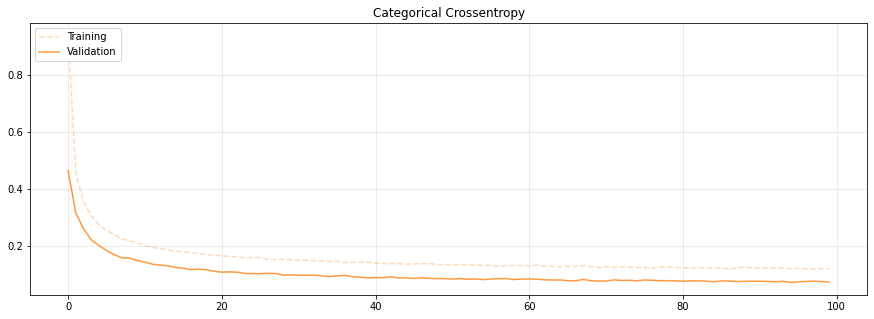

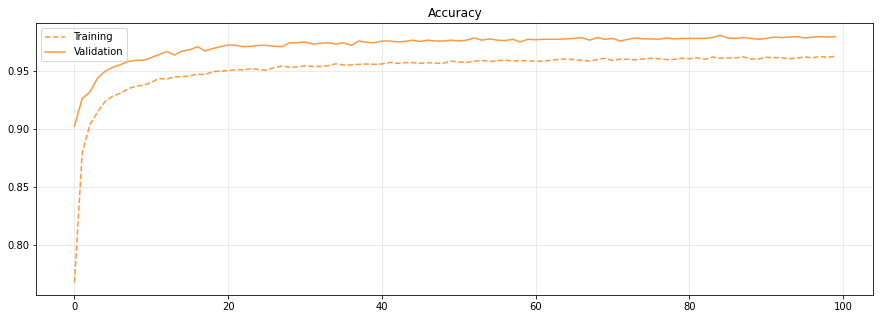

In [25]:
plot_history(history)

### Validation results

In [25]:
# model = tfk.models.load_model('CNN38')

In [26]:
# Confusion Matrix and Classification Report
classif_report(model)

Confusion Matrix
[[181   1   4   0   1   0   0   1   1   0   0   0   0   1]
 [  1 188   0   0   0   0   0   1   0   0   0   0   0   0]
 [  2   0 186   0   0   0   0   1   0   0   0   0   0   1]
 [  0   0   0 190   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 190   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 190   0   0   0   0   0   0   0   0]
 [  1   0   0   1   0   0 187   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   1 183   0   0   0   0   0   6]
 [  2   0   0   0   1   0   0   0 182   0   0   0   0   5]
 [  1   0   0   0   0   0   0   0   0 188   0   0   0   1]
 [  2   0   1   0   0   0   0   1   0   0 184   0   0   2]
 [  0   0   0   0   3   0   0   0   0   0   0 187   0   0]
 [  1   0   0   0   1   0   0   0   2   0   0   0 185   1]
 [  2   0   0   0   0   0   0   1   1   0   1   0   1 184]]

Classification Report


              precision    recall  f1-score   support

       Apple       0.94      0.95      0.95       190
   Blueberry       0.9

## Fine Tuning

In this phase we reload the previous model and we retrain it by unfreezing all the Xception layers from the 126th on. <br>
We also decrease the learning rate to 1e-5.

In [27]:
# Reload the model after transfer learning
model = tfk.models.load_model('CNN38')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 14)                28686     
Total params: 20,890,166
Trainable params: 28,686
Non-trainable params: 20,861,480
_________________________________________________________________


In [28]:
# set all Xception layers to trainable
model.get_layer('xception').trainable = True

for i, layer in enumerate(model.get_layer('xception').layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d_6 True
13 block2_pool True
14 batch_normalization_8 True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_7 True
23 block3_pool True
24 batch_normalization_9 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_8 True
33 block4_pool True
34 batch_normalization_10 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block

In [29]:
# freeze Xception layers until 126
for i, layer in enumerate(model.get_layer('xception').layers[:126]):
    layer.trainable = False
    
for i, layer in enumerate(model.get_layer('xception').layers):
    print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_6 False
13 block2_pool False
14 batch_normalization_8 False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_7 False
23 block3_pool False
24 batch_normalization_9 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_8 False
33 block4_pool False
34 batch_normalization_10 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 

In [30]:
# Compile the model
# We decrease the learning rate to 1e-5
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics='accuracy')

### Training

In [31]:
aug_callbacks = create_folders_and_callbacks(model_name='CNN38_126') # create folders and callbacks for training

tf.get_logger().setLevel('WARNING') # if you want to suppress only INFOs 

history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = aug_callbacks,
).history

C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
4816/4816 [==============================] - 1475s 306ms/step - loss: 0.2055 - accuracy: 0.9369 - val_loss: 0.0440 - val_accuracy: 0.9850


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
4816/4816 [==============================] - 1602s 333ms/step - loss: 0.1073 - accuracy: 0.9654 - val_loss: 0.0344 - val_accuracy: 0.9895


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/100
4816/4816 [==============================] - 1637s 340ms/step - loss: 0.0819 - accuracy: 0.9736 - val_loss: 0.0296 - val_accuracy: 0.9932


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/100
4816/4816 [==============================] - 1620s 336ms/step - loss: 0.0628 - accuracy: 0.9790 - val_loss: 0.0247 - val_accuracy: 0.9944


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/100
4816/4816 [==============================] - 1689s 351ms/step - loss: 0.0530 - accuracy: 0.9824 - val_loss: 0.0216 - val_accuracy: 0.9951


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/100
4816/4816 [==============================] - 1668s 346ms/step - loss: 0.0448 - accuracy: 0.9850 - val_loss: 0.0237 - val_accuracy: 0.9940


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/100
4816/4816 [==============================] - 1728s 359ms/step - loss: 0.0383 - accuracy: 0.9874 - val_loss: 0.0183 - val_accuracy: 0.9966


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/100
4816/4816 [==============================] - 1745s 362ms/step - loss: 0.0357 - accuracy: 0.9890 - val_loss: 0.0207 - val_accuracy: 0.9947


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/100
4816/4816 [==============================] - 1742s 362ms/step - loss: 0.0306 - accuracy: 0.9901 - val_loss: 0.0174 - val_accuracy: 0.9955


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/100
4816/4816 [==============================] - 1804s 374ms/step - loss: 0.0270 - accuracy: 0.9914 - val_loss: 0.0170 - val_accuracy: 0.9951


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/100
4816/4816 [==============================] - 1822s 378ms/step - loss: 0.0268 - accuracy: 0.9909 - val_loss: 0.0160 - val_accuracy: 0.9962


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/100
4816/4816 [==============================] - 1831s 380ms/step - loss: 0.0232 - accuracy: 0.9922 - val_loss: 0.0161 - val_accuracy: 0.9959


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/100
4816/4816 [==============================] - 1821s 378ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.0195 - val_accuracy: 0.9955


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/100
4816/4816 [==============================] - 1835s 381ms/step - loss: 0.0202 - accuracy: 0.9931 - val_loss: 0.0175 - val_accuracy: 0.9959


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/100
4816/4816 [==============================] - 1816s 377ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.0166 - val_accuracy: 0.9970


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/100
4816/4816 [==============================] - 1838s 382ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.0153 - val_accuracy: 0.9974


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/100
4816/4816 [==============================] - 1861s 386ms/step - loss: 0.0171 - accuracy: 0.9943 - val_loss: 0.0148 - val_accuracy: 0.9974


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/100
4816/4816 [==============================] - 1742s 362ms/step - loss: 0.0153 - accuracy: 0.9947 - val_loss: 0.0187 - val_accuracy: 0.9959


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/100
4816/4816 [==============================] - 1789s 371ms/step - loss: 0.0160 - accuracy: 0.9945 - val_loss: 0.0166 - val_accuracy: 0.9970


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/100
4816/4816 [==============================] - 1784s 370ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0167 - val_accuracy: 0.9970


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/100
4816/4816 [==============================] - 1880s 390ms/step - loss: 0.0134 - accuracy: 0.9952 - val_loss: 0.0159 - val_accuracy: 0.9977


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/100
4816/4816 [==============================] - 1878s 390ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.0165 - val_accuracy: 0.9970


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/100
4816/4816 [==============================] - 1835s 381ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.0154 - val_accuracy: 0.9974


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/100
4816/4816 [==============================] - 1887s 392ms/step - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.0140 - val_accuracy: 0.9974


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/100
4816/4816 [==============================] - 1891s 393ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 0.0181 - val_accuracy: 0.9966


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/100
4816/4816 [==============================] - 1783s 370ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.0166 - val_accuracy: 0.9970


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/100
4816/4816 [==============================] - 1790s 372ms/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.0163 - val_accuracy: 0.9970


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/100
4816/4816 [==============================] - 1823s 378ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0163 - val_accuracy: 0.9970


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/100
4816/4816 [==============================] - 1834s 381ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.0144 - val_accuracy: 0.9977


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/100
4816/4816 [==============================] - 1913s 397ms/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 0.0153 - val_accuracy: 0.9977


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/100
4816/4816 [==============================] - 1931s 401ms/step - loss: 0.0089 - accuracy: 0.9969 - val_loss: 0.0155 - val_accuracy: 0.9974


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 32/100
4816/4816 [==============================] - 1811s 376ms/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.0169 - val_accuracy: 0.9970


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 33/100
4816/4816 [==============================] - 1822s 378ms/step - loss: 0.0079 - accuracy: 0.9974 - val_loss: 0.0157 - val_accuracy: 0.9966


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/100
4816/4816 [==============================] - 1805s 375ms/step - loss: 0.0079 - accuracy: 0.9973 - val_loss: 0.0147 - val_accuracy: 0.9970


C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [32]:
# Save the model
model.save('CNN38_126')

C:\Users\mario\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Plot the training

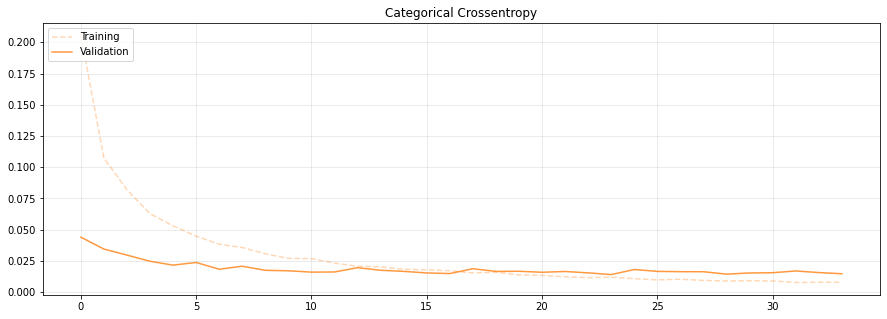

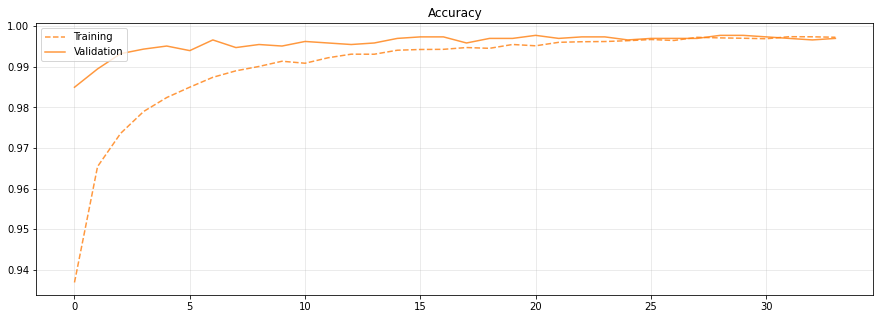

In [33]:
plot_history(history)

### Validation results

In [31]:
# model = tfk.models.load_model('CNN38_126')

In [34]:
# Confution Matrix and Classification Report
classif_report(model)

Confusion Matrix
[[188   0   0   0   0   0   0   0   0   0   1   0   0   1]
 [  0 190   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 189   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0 190   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 190   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 190   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 190   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 190   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0 188   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0 190   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 190   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0 189   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0 189   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 190]]

Classification Report


              precision    recall  f1-score   support

       Apple       0.99      0.99      0.99       190
   Blueberry       1.0